# Clasificador de SPAM (TF‑IDF + Naive Bayes) con MLflow

Este cuaderno entrena un modelo de clasificación de SPAM usando **TF‑IDF** y **Multinomial Naive Bayes**, y registra métricas/artefactos en **MLflow**.

**Pasos**:
1. Carga y preparación del dataset (`spam_dataset.csv`).
2. Vectorización con TF‑IDF.
3. Entrenamiento y validación (F1 con CV).
4. Evaluación en test (accuracy, precision, recall, f1).
5. Log de métricas/artefactos/modelo en MLflow.

> Requisitos: `pandas`, `numpy`, `scikit-learn`, `matplotlib`, `mlflow`.


In [2]:
# Instalar librerias
!pip install -q mlflow scikit-learn pandas numpy matplotlib


In [ ]:
import os, mlflow, pathlib

local_store = pathlib.Path.cwd() / "mlruns"
local_store.mkdir(parents=True, exist_ok=True)

mlflow.set_tracking_uri(f"file://{local_store.resolve()}")
print("Tracking URI:", mlflow.get_tracking_uri())

In [5]:
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_score,
    accuracy_score, recall_score, f1_score, ConfusionMatrixDisplay
)

import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)


## Carga y preparación del dataset

In [7]:
# Lectura de archivo 'spam_dataset.csv' 

df = pd.read_csv("spam_dataset.csv")
display(df.head())

X = df['message_content']
y = df['is_spam']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
len(x_train), len(x_test)


,message_content,is_spam
0,"Hello Lonnie,\n\nJust wanted to touch base reg...",0
1,"Congratulations, you've won a prize! Call us n...",1
2,You have been pre-approved for a credit card w...,1
3,"Limited time offer, act now! Only a few spots ...",1
4,Your loan has been approved! Transfer funds to...,1


(700, 300)

## Pipeline TF‑IDF + MultinomialNB y validación cruzada (F1)

In [8]:
params = {
    "tfidf_stop_words": "english",
    "tfidf_ngram_range": (1, 1),
    "tfidf_min_df": 1,
    "tfidf_max_df": 1.0,
    "nb_alpha": 1.0,
    "nb_fit_prior": True,
}

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words=params["tfidf_stop_words"],
        ngram_range=params["tfidf_ngram_range"],
        min_df=params["tfidf_min_df"],
        max_df=params["tfidf_max_df"]
    )),
    ("clf", MultinomialNB(
        alpha=params["nb_alpha"],
        fit_prior=params["nb_fit_prior"]
    )),
])

# Validación cruzada en train (F1)
x_train_vec = TfidfVectorizer(
    stop_words=params["tfidf_stop_words"],
    ngram_range=params["tfidf_ngram_range"],
    min_df=params["tfidf_min_df"],
    max_df=params["tfidf_max_df"]
).fit_transform(x_train)

base_nb = MultinomialNB(alpha=params["nb_alpha"], fit_prior=params["nb_fit_prior"])
cv_scores = cross_val_score(base_nb, X=x_train_vec, y=y_train, cv=5, scoring='f1')

print("CV F1 scores:", cv_scores)
print("CV F1 mean:", np.mean(cv_scores))
print("CV F1 std:", np.std(cv_scores))


CV F1 scores: [1. 1. 1. 1. 1.]
CV F1 mean: 1.0
CV F1 std: 0.0


## Entrenamiento y Validación

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       150
           1     1.0000    1.0000    1.0000       150

    accuracy                         1.0000       300
   macro avg     1.0000    1.0000    1.0000       300
weighted avg     1.0000    1.0000    1.0000       300



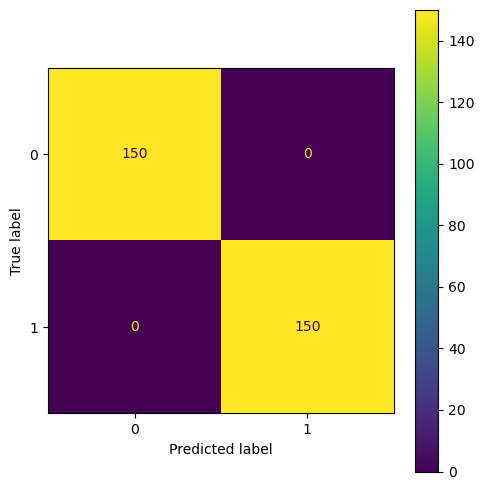

{'accuracy_test': 1.0,
 'precision_test': 1.0,
 'recall_test': 1.0,
 'f1_test': 1.0,
 'cv_f1_mean': 1.0,
 'cv_f1_std': 0.0}

In [9]:
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)

print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax)
fig.tight_layout()
plt.show()

metrics = {
    "accuracy_test": accuracy_score(y_test, y_pred),
    "precision_test": precision_score(y_test, y_pred, zero_division=0),
    "recall_test": recall_score(y_test, y_pred, zero_division=0),
    "f1_test": f1_score(y_test, y_pred, zero_division=0),
    "cv_f1_mean": float(np.mean(cv_scores)),
    "cv_f1_std": float(np.std(cv_scores)),
}
metrics


## Registro en MLflow (métricas, artefactos y modelo)

In [ ]:
mlflow.set_experiment("spam_nb_experiment")

with mlflow.start_run(run_name="nb_tfidf_v1") as run:
    # Parámetros
    mlflow.log_params({
        "tfidf_stop_words": params["tfidf_stop_words"],
        "tfidf_ngram_range": str(params["tfidf_ngram_range"]),
        "tfidf_min_df": params["tfidf_min_df"],
        "tfidf_max_df": params["tfidf_max_df"],
        "nb_alpha": params["nb_alpha"],
        "nb_fit_prior": params["nb_fit_prior"],
    })

    # Métricas
    mlflow.log_metrics(metrics)

    # Artefactos (reporte + matriz de confusión)
    os.makedirs("artifacts", exist_ok=True)

    # Reporte
    report_txt = classification_report(y_test, y_pred, digits=4)
    report_path = os.path.join("artifacts", "classification_report.txt")
    with open(report_path, "w") as f:
        f.write(report_txt)
    mlflow.log_artifact(report_path, artifact_path="reports")

    # Imagen de la matriz de confusión
    fig, ax = plt.subplots(figsize=(5,5))
    ConfusionMatrixDisplay(cm).plot(ax=ax)
    fig.tight_layout()
    cm_path = os.path.join("artifacts", "confusion_matrix.png")
    fig.savefig(cm_path, dpi=150)
    plt.close(fig)
    mlflow.log_artifact(cm_path, artifact_path="plots")

    # Modelo + firma y ejemplo
    input_example = ["Get FREE coupons now!!!"]
    signature = infer_signature(input_example, pipe.predict(input_example))
    mlflow.sklearn.log_model(
        sk_model=pipe,
        artifact_path="model",
        signature=signature,
        input_example=input_example
    )

    print("Run ID:", run.info.run_id)
    print("Artifact URI:", mlflow.get_artifact_uri())


### Ver resultados en la UI de MLflow
Ejecutá en una terminal:
```bash
mlflow ui --host 0.0.0.0 --port 5000
```
Luego abrí: `http://localhost:5000`
